In [1]:
from __future__ import annotations
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from numpy.typing import NDArray
from jrmpc import jrmpc

In [2]:
# required only for interactive plot
import plotly.graph_objects as go

In [3]:
def interactive_plot(
    data: Tensor | NDArray | tuple[Tensor | NDArray, ...] | list[Tensor | NDArray],
    point_size: int = 3,
    opacity: float = 0.8,
    width: int = 500,
    height: int = 500,
) -> None:
    if not isinstance(data, (list, tuple)):
        data = [data]
    if isinstance(data, tuple):
        data = list(data)
    for i, x in enumerate(data):
        if isinstance(x, Tensor) and x.is_cuda:
            data[i] = x.cpu()
    traces = list()
    for pointcloud in data:
        x, y, z = pointcloud
        c = pointcloud.norm(dim=0)
        marker_kwargs = dict(size=point_size, opacity=opacity, color=c)
        scatter_kwargs = dict(visible=True, mode='markers', marker=marker_kwargs)
        traces.append(go.Scatter3d(x=x, y=y, z=z, **scatter_kwargs))
    layout = dict(
        width=width, height=height,
        xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), margin=dict(t=50)
    )
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

In [4]:
def so3_relative_angle(R1: Tensor, R2: Tensor) -> Tensor:
    """ Geodesic distance in SO(3). R1 & R2 are batches of rotation matrices (B, 3, 3). """
    cos_theta = (torch.einsum('bij,bij->b', R1, R2) - 1) / 2
    cos_theta = torch.clamp(cos_theta, -1, 1)
    return torch.acos(cos_theta) * 180 / torch.pi

In [5]:
def errors_jrmpc(R_hat: Tensor, R_gt: Tensor) -> Tensor:
    errors_jrmpc = list()
    M = len(R_hat)
    for i in range(M):
        for j in range(i):
            a = R_hat[i] @ R_gt[i]
            b = R_hat[j] @ R_gt[j]
            e = so3_relative_angle(a.unsqueeze(0), b.unsqueeze(0)).squeeze()
            errors_jrmpc.append(e)
    errors_jrmpc = torch.hstack(errors_jrmpc)
    errors_jrmpc = errors_jrmpc[errors_jrmpc > 0]
    return errors_jrmpc

___

In [6]:
data = torch.load('sample_data.pt')
views, R_gt = data['views'], data['R_gt']

In [7]:
print(views.shape)
print(R_gt.shape)

torch.Size([100, 3, 1024])
torch.Size([100, 3, 3])


In [8]:
# outputs = jrmpc(views.numpy(), max_num_iter=20, progress_bar=True)
outputs = jrmpc(views.cuda(), max_num_iter=20, progress_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
R_hat, t_hat = outputs.R.cpu(), outputs.t.cpu()

In [10]:
avg_rotation_error_evolution = [errors_jrmpc(r, R_gt).mean() for r in outputs.history['R']] 

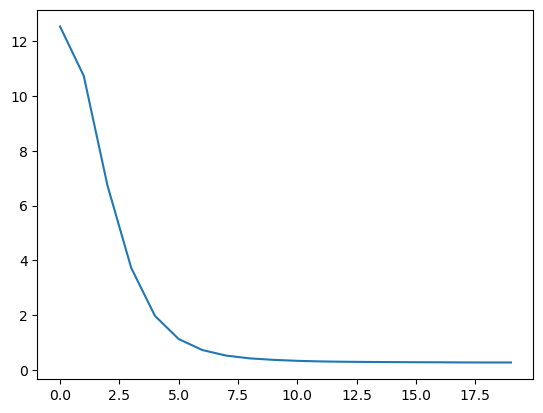

In [11]:
plt.plot(avg_rotation_error_evolution)
plt.show()

In [12]:
final_rotation_errors = errors_jrmpc(R_hat, R_gt)

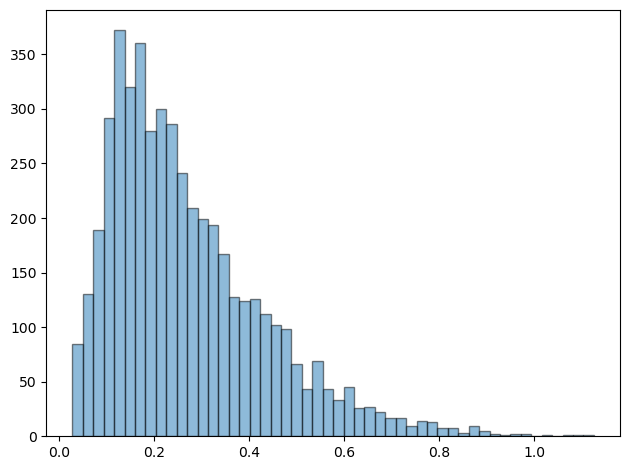

In [13]:
plt.hist(final_rotation_errors, bins=50, edgecolor='k', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
V_registered = [r @ v + t for v, r, t in zip(views, R_hat, t_hat)]

In [15]:
# interactive_plot((*views[:5],))
interactive_plot((*V_registered[:5],))

In [16]:
interactive_plot(outputs.X)